In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
database_path = "C:/Users/User/SQLiteHW/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
ws_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-02-28').\
    filter(Measurement.date <= '2016-03-05').\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).all()

In [35]:
ws_rainfall

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [61]:
#Another way to do it. 

In [58]:
#set the start and end date for the trip 
startDate = "2016-04-08"
endDate = "2016-04-19"
#calculate trip length
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1
#start date as datetime object
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')
#list dates (MM-DD) of trip
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d')
            for x in range(0, tripLength)]
#calculate normals for each date
tripNormals = [daily_normals(date) for date in dateList]
tripNormals

[[(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)],
 [(61.0, 71.79310344827586, 79.0)],
 [(62.0, 71.55357142857143, 81.0)],
 [(65.0, 71.93103448275862, 77.0)],
 [(67.0, 72.49152542372882, 77.0)],
 [(65.0, 72.42105263157895, 83.0)]]

In [51]:
# Set the start and end date of the trip
trip_start = '2016-04-08'
trip_end = '2016-04-19'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')
# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

In [52]:
trip_month_day

Index(['04-08', '04-09', '04-10', '04-11', '04-12', '04-13', '04-14', '04-15',
       '04-16', '04-17', '04-18', '04-19'],
      dtype='object')

In [53]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))

In [54]:
normals

[(66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0)]

In [59]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#extract normals into a list of lists
tripNormals = [np.array(normal[0]) for normal in tripNormals]
#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})
normalsTable

,Low Temp,Avg Temp,High Temp
Date,,,
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0


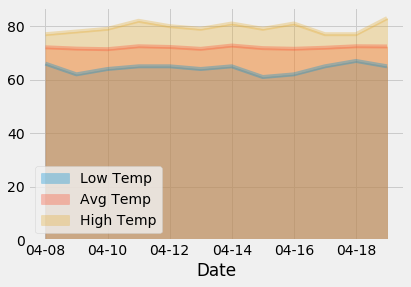

In [62]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.333)
plt.savefig('Trip Normals.png')